#                             Etude Environnementale [Axe spatio-temporel] 

Cette Etude investigera les questions suivantes: 
• Est ce qu'il y a une relation entre les types de routes ,ou les conditions de conduite , et le degré d'occurence des sinistres automobiles corporels? 
• Comment varie les conditions d'accidents parmi les communes ? 
J'esserai de répondre à ces questions en étudiant les relations  entre  les accidents et les cas fatales et: 
• Catégorie de route 
• Conditions lumière
• Conditions météo 
• Conditions surfaces de routes 

Plan:
*Etudier les collisions pendant toute l'année et pendant la journée.
*Investiger les données groupés par commune et identifier les correlations entre les conditions environnementales et le taux d'accidents. Ceci dit , un modèle de regression linéaire sera utilisé pour décrire cette relation.
*Identifion les clusters de communes avec des conditons environnementales similaires pour ainsi évaluer leurs propagations sur tout le pays et comment ceci est comparé avec le modèle.

In [4]:
import numpy as np
import pandas as pd
#import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import dates as dates
from matplotlib.ticker import NullFormatter
import seaborn as sns
from sklearn.preprocessing import quantile_transform, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy import stats

In [6]:
crct = pd.read_csv('caracteristiques-2017.csv',encoding='latin-1')
veh = pd.read_csv('vehicules-2017.csv',encoding='latin-1')
usager = pd.read_csv('usagers-2017.csv',encoding='latin-1')
lieux = pd.read_csv('lieux-2017.csv',encoding='latin-1',low_memory=False)

# Data Preparation

In [7]:
crct.head()

Num_Acc  an  mois  jour  hrmn  lum  agg  int  atm  col  com  \
0  201700000001  17     1    11  1820    5    2    1  1.0  1.0  477   
1  201700000002  17     2    13  1630    1    2    3  1.0  3.0    5   
2  201700000003  17     3     7  1150    1    2    9  1.0  5.0   52   
3  201700000004  17     4    22  1300    1    2    1  1.0  6.0    5   
4  201700000005  17     5    20  1230    1    2    1  1.0  2.0   11   

                  adr gps        lat      long  dep  
0       rue nationale   M  5051326.0  292191.0  590  
1    5 rue sonneville   M  5053611.0  295314.0  590  
2    rue Jules Guesde   M  5052174.0  288786.0  590  
3   46 rue Sonneville   M  5053723.0  295700.0  590  
4  Rue roger salengro   M  5052999.0  293798.0  590

In [8]:
l = lieux.drop(['voie','v1','v2','circ','pr','pr1','vosp','prof','plan','lartpc','larrout','infra'],1)
ac = crct.merge(l,on='Num_Acc')

In [9]:
u = usager.drop(['place','catu','sexe','trajet','secu','locp','actp','etatp','an_nais','num_veh'],1)
nu= u.drop_duplicates()
nu = nu.drop_duplicates(subset='Num_Acc', keep='first', inplace=False)
nu
acc_env = ac.merge(nu,on='Num_Acc')
acc_env.columns

Index(['Num_Acc', 'an', 'mois', 'jour', 'hrmn', 'lum', 'agg', 'int', 'atm',
       'col', 'com', 'adr', 'gps', 'lat', 'long', 'dep', 'catr', 'nbv', 'surf',
       'situ', 'env1', 'grav'],
      dtype='object')

In [10]:
acc_env=acc_env.rename(columns={"lum":"Conditions_lumière","grav":"Gravité_accident","atm":"Atmosphere","com":"Commune","int":"Intersections","col":"Collision","surf":"Conditions_Surface","lat":"Latitude","long":"Longitude","agg":"Agglomération","catr":"Catégorie_Route","dep":"Département"})
env_data=acc_env.drop(['situ','env1','nbv','gps','adr','Collision','Intersections'],1)

In [10]:
print(env_data.isnull().sum())

Num_Acc                  0
an                       0
mois                     0
jour                     0
hrmn                     0
Conditions_lumière       0
Agglomération            0
Atmosphere              13
Commune                  0
Latitude              7731
Longitude             7731
Département              0
Catégorie_Route          0
Conditions_Surface     465
Gravité_accident         0
dtype: int64


In [11]:
env_data.head()

Num_Acc  an  mois  jour  hrmn  Conditions_lumière  Agglomération  \
0  201700000001  17     1    11  1820                   5              2   
1  201700000002  17     2    13  1630                   1              2   
2  201700000003  17     3     7  1150                   1              2   
3  201700000004  17     4    22  1300                   1              2   
4  201700000005  17     5    20  1230                   1              2   

   Atmosphere  Commune   Latitude  Longitude  Département  Catégorie_Route  \
0         1.0      477  5051326.0   292191.0          590                3   
1         1.0        5  5053611.0   295314.0          590                3   
2         1.0       52  5052174.0   288786.0          590                3   
3         1.0        5  5053723.0   295700.0          590                3   
4         1.0       11  5052999.0   293798.0          590                3   

   Conditions_Surface  Gravité_accident  
0                 1.0                 3  
1                 1.0                 1  
2                 1.0                 1  
3                 1.0                 3  
4                 1.0                 3

In [12]:
env_data['Conditions_Surface'].fillna(env_data.Conditions_Surface.mode()[0],inplace=True)
env_data['Atmosphere'].fillna(env_data.Atmosphere.mode()[0],inplace=True)

#### Clarifier les noms des modalités d'après le descriptif des variables

In [13]:
env_data["Gravité_accident"].replace([1,2,3,4],["Non Grave","Fatale","Sévère","Léger "], inplace=True)
env_data["Conditions_lumière"].replace([1,2,3,4,5],["Plein jour","Crépuscule ou aube","Nuit sans éclairage public","Nuit avec éclairage public non allumé","Nuit avec éclairage public allumé"], inplace=True)
env_data["Agglomération"].replace([1,2],["Hors agglomération","En agglomération"], inplace=True)
env_data["Atmosphere"].replace([1,2,3,4,5,6,7,8,9],["Normale","Pluie légère","Pluie forte","Neige-gêlé","Brouillard fumée","Vent fort-tempête","Temps eblouissant","Temps couvert","Autre"], inplace=True)
env_data["Agglomération"].replace([1,2],["Hors agglomération","En agglomération"], inplace=True)
env_data["Catégorie_Route"].replace([1,2,3,4,5,6,9],["Autoroute","Route Nationale","Route Départementale","Voie Communale","Hors réseau public","ParcStationOuvCirPub","Autre"], inplace=True)
env_data["Conditions_Surface"].replace([1,2,3,4,5,6,7,8,9],["Normale","Mouillée","Flaques","Inondée","Enneigée","Boue","Verglacée","Corps gras-huile","Autre"], inplace=True)

In [14]:
env_data.head()

Num_Acc  an  mois  jour  hrmn                 Conditions_lumière  \
0  201700000001  17     1    11  1820  Nuit avec éclairage public allumé   
1  201700000002  17     2    13  1630                         Plein jour   
2  201700000003  17     3     7  1150                         Plein jour   
3  201700000004  17     4    22  1300                         Plein jour   
4  201700000005  17     5    20  1230                         Plein jour   

      Agglomération Atmosphere  Commune   Latitude  Longitude  Département  \
0  En agglomération    Normale      477  5051326.0   292191.0          590   
1  En agglomération    Normale        5  5053611.0   295314.0          590   
2  En agglomération    Normale       52  5052174.0   288786.0          590   
3  En agglomération    Normale        5  5053723.0   295700.0          590   
4  En agglomération    Normale       11  5052999.0   293798.0          590   

        Catégorie_Route Conditions_Surface Gravité_accident  
0  Route Départementale            Normale           Sévère  
1  Route Départementale            Normale        Non Grave  
2  Route Départementale            Normale        Non Grave  
3  Route Départementale            Normale           Sévère  
4  Route Départementale            Normale           Sévère

In [15]:
usagers = pd.read_csv('usagers-2017-préparé.csv',encoding="utf-16")


In [16]:
#Ajouter données usager dans la table principale
fatalitées = pd.get_dummies(usagers['Gravité_accident'])
fatalitées = fatalitées[['Tué','Blessé hospitalisé']]
fatalitées = fatalitées[(fatalitées['Tué']==1)|(fatalitées['Blessé hospitalisé']==1)]
usagerCount = pd.concat([usagers['Num_Acc'], fatalitées], axis=1)
usagerCount.dropna(inplace=True)
usagerCount = usagerCount.groupby('Num_Acc').sum()
acc_env = env_data.join(usagerCount,on='Num_Acc')
acc_env['Nombre_Accident']=1
acc_env.fillna(value=0,inplace=True)

new_df = acc_env[(acc_env['Conditions_lumière']!='Data missing or out of range') &
              (acc_env['Atmosphere']!='Data missing or out of range') &
              (acc_env['Atmosphere']!='Unknown') &
              (acc_env['Conditions_Surface']!='Data missing or out of range')]

#Créer la table de dummies pour les colonnes en question
dummies = pd.get_dummies(new_df[['Conditions_lumière','Atmosphere',
                                'Conditions_Surface']])

#Reset index
dummies.reset_index(inplace=True)
dummies.drop('index',axis=1,inplace=True)

#Add row for national totals
dummySum = dummies.sum(axis=0)
dummies = dummies.append(dummySum.transpose(),ignore_index=True)
dummies.loc[len(dummies)-1,'totNat'] = 'Total National'
dummies.fillna(value=0,inplace=True)



In [17]:
new_df.head()

Num_Acc  an  mois  jour  hrmn                 Conditions_lumière  \
0  201700000001  17     1    11  1820  Nuit avec éclairage public allumé   
1  201700000002  17     2    13  1630                         Plein jour   
2  201700000003  17     3     7  1150                         Plein jour   
3  201700000004  17     4    22  1300                         Plein jour   
4  201700000005  17     5    20  1230                         Plein jour   

      Agglomération Atmosphere  Commune   Latitude  Longitude  Département  \
0  En agglomération    Normale      477  5051326.0   292191.0          590   
1  En agglomération    Normale        5  5053611.0   295314.0          590   
2  En agglomération    Normale       52  5052174.0   288786.0          590   
3  En agglomération    Normale        5  5053723.0   295700.0          590   
4  En agglomération    Normale       11  5052999.0   293798.0          590   

        Catégorie_Route Conditions_Surface Gravité_accident  Tué  \
0  Route Départementale            Normale           Sévère  0.0   
1  Route Départementale            Normale        Non Grave  0.0   
2  Route Départementale            Normale        Non Grave  0.0   
3  Route Départementale            Normale           Sévère  0.0   
4  Route Départementale            Normale           Sévère  0.0   

   Blessé hospitalisé  Nombre_Accident  
0                 3.0                1  
1                 1.0                1  
2                 1.0                1  
3                 1.0                1  
4                 1.0                1

In [18]:
new_df.to_csv('acc_env.csv',encoding="utf-16",index=False)

In [ ]:
#préparer la date avec le script R date qui sera nécessaire pour les visualisations

In [18]:
date_df = pd.read_csv('new_env.csv',encoding='latin1')
date_df=date_df.drop(['weekdayshours','an','mois','jour','hrmn','Conditions_lumiÃ.re','AgglomÃ.ration','Atmosphere','Commune','Latitude'
,'Conditions_Surface','GravitÃ._accident','TuÃ.','BlessÃ..hospitalisÃ.','Nombre_Accident','Longitude','DÃ.partement'
,'CatÃ.gorie_Route'],1)

In [19]:
df_final = new_df.merge(date_df,on='Num_Acc')
df_final.head()

Num_Acc  an  mois  jour  hrmn                 Conditions_lumière  \
0  201700000001  17     1    11  1820  Nuit avec éclairage public allumé   
1  201700000002  17     2    13  1630                         Plein jour   
2  201700000003  17     3     7  1150                         Plein jour   
3  201700000004  17     4    22  1300                         Plein jour   
4  201700000005  17     5    20  1230                         Plein jour   

      Agglomération Atmosphere  Commune   Latitude ...   Conditions_Surface  \
0  En agglomération    Normale      477  5051326.0 ...              Normale   
1  En agglomération    Normale        5  5053611.0 ...              Normale   
2  En agglomération    Normale       52  5052174.0 ...              Normale   
3  En agglomération    Normale        5  5053723.0 ...              Normale   
4  En agglomération    Normale       11  5052999.0 ...              Normale   

   Gravité_accident  Tué Blessé hospitalisé Nombre_Accident  \
0            Sévère  0.0                3.0               1   
1         Non Grave  0.0                1.0               1   
2         Non Grave  0.0                1.0               1   
3            Sévère  0.0                1.0               1   
4            Sévère  0.0                1.0               1   

              datetime        date  year   wday hour  
0  2017-01-11 18:20:00  2017-01-11  2017  mer\.   18  
1  2017-02-13 16:30:00  2017-02-13  2017  lun\.   16  
2  2017-03-07 11:50:00  2017-03-07  2017  mar\.   11  
3  2017-04-22 13:00:00  2017-04-22  2017  sam\.   13  
4  2017-05-20 12:30:00  2017-05-20  2017  sam\.   12  

[5 rows x 23 columns]

In [20]:
df_final["wday"].replace(["lun\.","mar\.","mer\.","jeu\.","ven\.","sam\.","dim\."],
                                  ["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche",], inplace=True)

In [21]:
df_final["mois"].replace([1,2,3,4,5,6,7,8,9,10,11,12],
    ["Janvier","Février","Mars","Avril","Mai","Juin","Juillet","Aout","Septembre","Octobre","Novembre","Décembre"], inplace=True)

In [ ]:
#################################################################################################################################

# Data Analysis

In [22]:
df_final.head()

Num_Acc  an     mois  jour  hrmn                 Conditions_lumière  \
0  201700000001  17  Janvier    11  1820  Nuit avec éclairage public allumé   
1  201700000002  17  Février    13  1630                         Plein jour   
2  201700000003  17     Mars     7  1150                         Plein jour   
3  201700000004  17    Avril    22  1300                         Plein jour   
4  201700000005  17      Mai    20  1230                         Plein jour   

      Agglomération Atmosphere  Commune   Latitude ...   Conditions_Surface  \
0  En agglomération    Normale      477  5051326.0 ...              Normale   
1  En agglomération    Normale        5  5053611.0 ...              Normale   
2  En agglomération    Normale       52  5052174.0 ...              Normale   
3  En agglomération    Normale        5  5053723.0 ...              Normale   
4  En agglomération    Normale       11  5052999.0 ...              Normale   

   Gravité_accident  Tué Blessé hospitalisé Nombre_Accident  \
0            Sévère  0.0                3.0               1   
1         Non Grave  0.0                1.0               1   
2         Non Grave  0.0                1.0               1   
3            Sévère  0.0                1.0               1   
4            Sévère  0.0                1.0               1   

              datetime        date  year      wday hour  
0  2017-01-11 18:20:00  2017-01-11  2017  Mercredi   18  
1  2017-02-13 16:30:00  2017-02-13  2017     Lundi   16  
2  2017-03-07 11:50:00  2017-03-07  2017     Mardi   11  
3  2017-04-22 13:00:00  2017-04-22  2017    Samedi   13  
4  2017-05-20 12:30:00  2017-05-20  2017    Samedi   12  

[5 rows x 23 columns]

In [23]:
#Configurer format date
df_final['date'] = pd.to_datetime(df_final['date'], format='%Y/%m/%d').dt.date
#df_final['hrmn'] = pd.to_datetime(acc16['hrmn'], format='%H:%M').dt.time
#df_final['Month'] = pd.DatetimeIndex(acc16['Date']).month

In [24]:
jours = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']

In [25]:
dummies = pd.concat([df_final[['Commune','Nombre_Accident',
                            'Blessé hospitalisé','Tué','date',
                            'wday','hour']], dummies],axis=1)

In [26]:
df_final["Conditions_Surface"].replace([0],["Boue"], inplace=True)

In [27]:
################## Prepare Initial visualisation ##############################

#Calculer la distribution des accidents durant toute l'année
#Grouper les accidents par date
byDate = df_final[['date','Num_Acc']].groupby('date').count()
byDate['date'] = byDate.index

#Identifier les valeurs aberrantes
dailyAccMean = byDate['Num_Acc'].mean()
dailyAccSD = byDate['Num_Acc'].std()

check_high = dailyAccMean + 2*dailyAccSD
check_low = dailyAccMean - 2*dailyAccSD
byDate['isOutlier'] = (byDate['Num_Acc'] > check_high)|(byDate['Num_Acc'] < check_low)
byDate['pltColour'] = '#B9BCC0'
byDate.loc[byDate['isOutlier'] == True, 'pltColour'] = 'r'

#Calculer la distribution des accidents durant la journée
byHour = df_final[['hour','Num_Acc']].groupby('hour').count()
byHour['Num_Acc'] = byHour['Num_Acc'].apply(lambda x: x/366) # Transformer total à valeur par jour

#Grouper les accidents pour chaque catégorie de route où ils ont occuré
byRoadType = df_final[['Nombre_Accident','Catégorie_Route','Blessé hospitalisé','Tué']].groupby('Catégorie_Route').sum()
byRoadType.reset_index(inplace=True)
byRoadType

Catégorie_Route  Nombre_Accident  Blessé hospitalisé     Tué
0             Autoroute             5692              1884.0   283.0
1                 Autre              744               377.0    51.0
2    Hors réseau public               68                38.0     2.0
3  ParcStationOuvCirPub              476               240.0    16.0
4  Route Départementale            21900             14767.0  2262.0
5       Route Nationale             3974              2088.0   312.0
6        Voie Communale            27847              9599.0   674.0

In [28]:
############### Etudier les données par date #######################################

#Calculer la distribution des accidents pendant tous les jours de la semaine

#pour toute l'année , plus spécifiquement juin et décembre 
byHourDay = df_final[['hour','wday','Nombre_Accident','Blessé hospitalisé','Tué']].groupby(['hour','wday']).sum().reset_index()
byHourDayJune = df_final.loc[df_final['mois'] == "Juin",['hour','wday','Nombre_Accident','Blessé hospitalisé','Tué']].groupby(['hour','wday']).sum().reset_index()
byHourDayDec = df_final.loc[df_final['mois'] == "Décembre",['hour','wday','Nombre_Accident','Blessé hospitalisé','Tué']].groupby(['hour','wday']).sum().reset_index()


In [29]:
AccbyHourDay = byHourDay.pivot(index='hour',columns='wday',values='Nombre_Accident')/366
AccbyHourDay = AccbyHourDay[jours]

In [30]:
AccbyHourDayJune = byHourDayJune.pivot(index='hour',columns='wday',values='Nombre_Accident')/30
AccbyHourDayJune = AccbyHourDayJune[jours]

In [31]:
AccbyHourDayDec = byHourDayDec.pivot(index='hour',columns='wday',values='Nombre_Accident')/31
AccbyHourDayDec = AccbyHourDayDec[jours]

In [32]:
SeriousbyHourDay = byHourDay.pivot(index='hour',columns='wday',values='Blessé hospitalisé')
SeriousbyHourDay = SeriousbyHourDay[jours]

In [33]:
DeathbyHourDay = byHourDay.pivot(index='hour',columns='wday',values='Tué')
DeathbyHourDay = DeathbyHourDay[jours]

## Distribution des Accidnets : Axe temporel

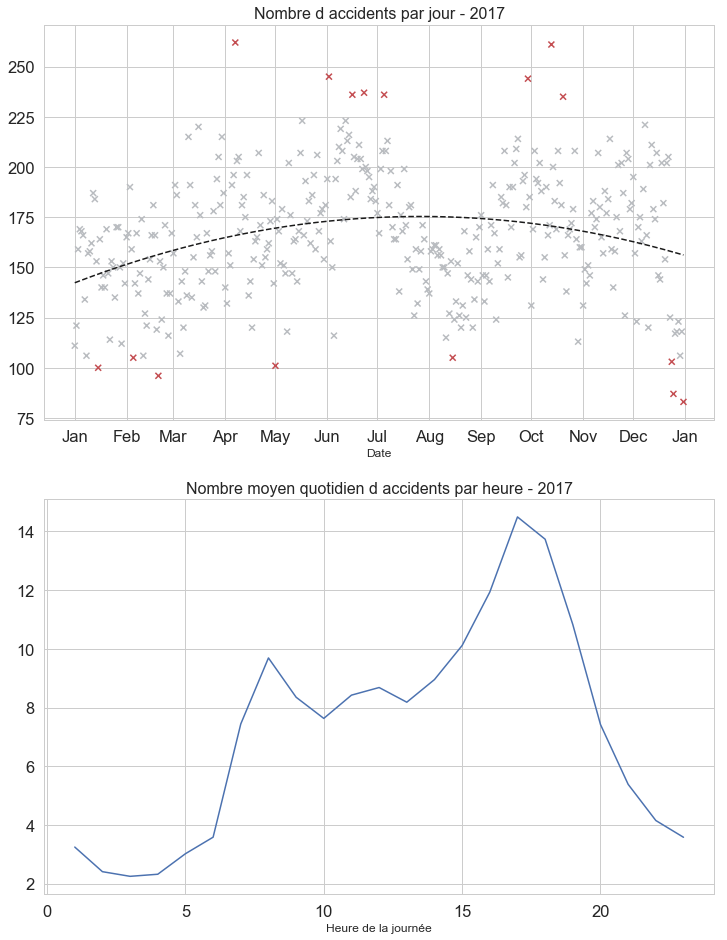

In [83]:

sns.set_style('whitegrid')
fig, ax = plt.subplots(2,1, figsize = (12,16))
plotDates = dates.date2num(byDate['date'])
plt.style.use('ggplot')
months = dates.MonthLocator()  # chaque mois
monthsFmt = dates.DateFormatter('%b')

#regréssion linéaire  sur les données regroupées par date
pCoeff = np.polyfit(plotDates, byDate['Num_Acc'], 2)
regLine = np.poly1d(pCoeff)



#plot par jour
ax[0].scatter(plotDates, byDate['Num_Acc'],marker= 'x', c= byDate['pltColour'])
ax[0].plot(plotDates, regLine(plotDates), 'k--')
ax[0].xaxis.set_major_locator(months)
ax[0].xaxis.set_major_formatter(monthsFmt)
ax[0].set_title('Nombre d accidents par jour - 2017', fontsize=16)
ax[0].set_xlabel('Date')

#plot par heure
ax[1].plot(byHour.index, byHour['Num_Acc'], c='b')
ax[1].set_title('Nombre moyen quotidien d accidents par heure - 2017', fontsize=16)
ax[1].set_xlabel('Heure de la journée')
plt.savefig('Time.png',bbox_inches='tight')


Figure 1: Distribution des accidents de la route  en France pendant 2017. 
Les valeurs aberrantes (>2sd de la moyenne) sont marqués en rouge. 

*Les Accidents ont été regroupés par date et leurs distribution durant l'année est visualisée dans cette figure.
On remarque qu'après l'été  le nombre  d'accidents baisse fortement et rebondit en début d'hiver. Ce qui montre  que l'automne est la saison la moins dangereuse de l'année.
Un point d'interet frappant  si on focalise  sur les 3 valeurs aberrantes positionnées en fin Décembre. Ce sont les 3 jours de l'année où il y a le moins d'accidents  : Noel, Boxing Day, et le réveillon.  


Figure 2:Distribution pendant les heures de la journée

*Cette figue montre que généralement les heures où il est plus probable d'avoir le plus d'accidents sont aux environs de 8h et de 17h ce qui n'est pas surprenant du au fiat que ce sont les heures d'entrée et sortie de travail présentant les plus de véhicules sur les routes.


## Distribution des Accidents : Axe Spatial

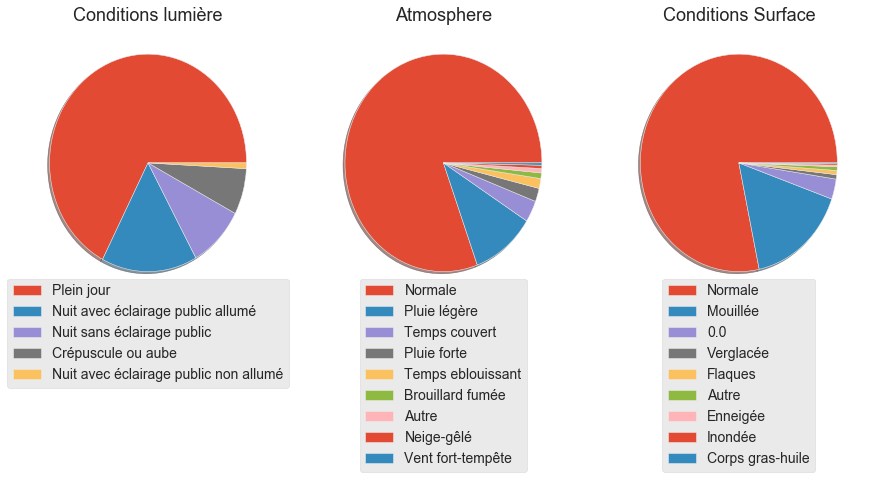

In [35]:
#Plot summary du nombre d'accidents toutes les valeurs de chaque conditon environnemetale
fig4,ax4 = plt.subplots(1,3,figsize=(15,5))
ax4[0].pie(df_final['Conditions_lumière'].value_counts(), shadow=True)
ax4[0].set_title('Conditions lumière',fontsize=18)
pieleg0 = ax4[0].legend(labels=env_data['Conditions_lumière'].value_counts().index,bbox_to_anchor=(0.5,0.1), fontsize=14,loc="upper center")
ax4[1].pie(df_final['Atmosphere'].value_counts(), shadow=True)
ax4[1].set_title('Atmosphere',fontsize=18)
pieleg1 = ax4[1].legend(labels=env_data['Atmosphere'].value_counts().index,bbox_to_anchor=(0.5,0.1), fontsize=14,loc="upper center")
ax4[2].pie(df_final['Conditions_Surface'].value_counts(), shadow=True)
ax4[2].set_title('Conditions Surface',fontsize=18)
pieleg2 = ax4[2].legend(labels=env_data['Conditions_Surface'].value_counts().index,bbox_to_anchor=(0.5,0.1), fontsize=14,loc="upper center")
#plt.savefig('Condition Pies.jpg', bbox_extra_artists=(pieleg0,pieleg1,pieleg2), bbox_inches='tight')
#plt.tight_layout()


*Toutes les  conditions environnementales ont montré une meme distirbution d'accidents, avec une catégorie augementant à 70-85% d'observations, une deuxième catégorie de 10-25%, et le reste est couvert par les conditions les plus rares. Ceci est tout à fait attendu car il est connu que  généralement en France le temps est clair et sec, mais parfois pluvieux, et la circulation est plus courante en pleine journée.  

### Visualisations Par catégorie de route

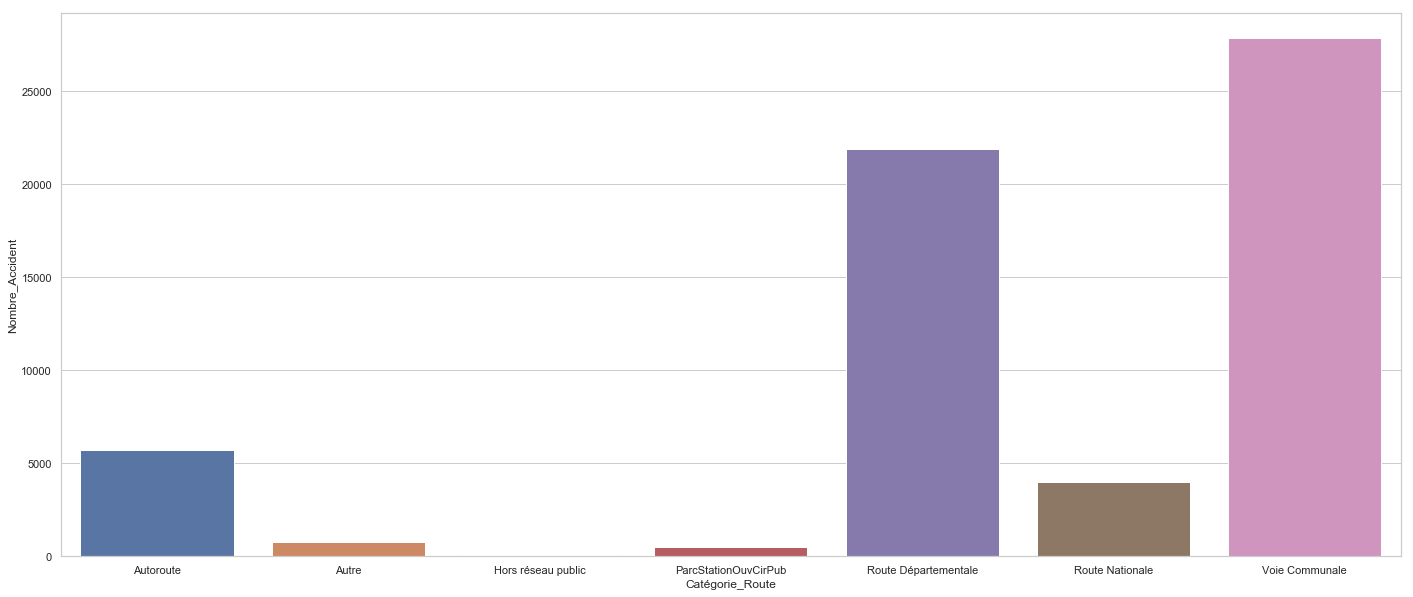

In [37]:
plt.figure(figsize=(24,10))
sns.set(style="whitegrid")
#Accidents
sns.barplot(x='Catégorie_Route', y='Nombre_Accident', data=byRoadType)

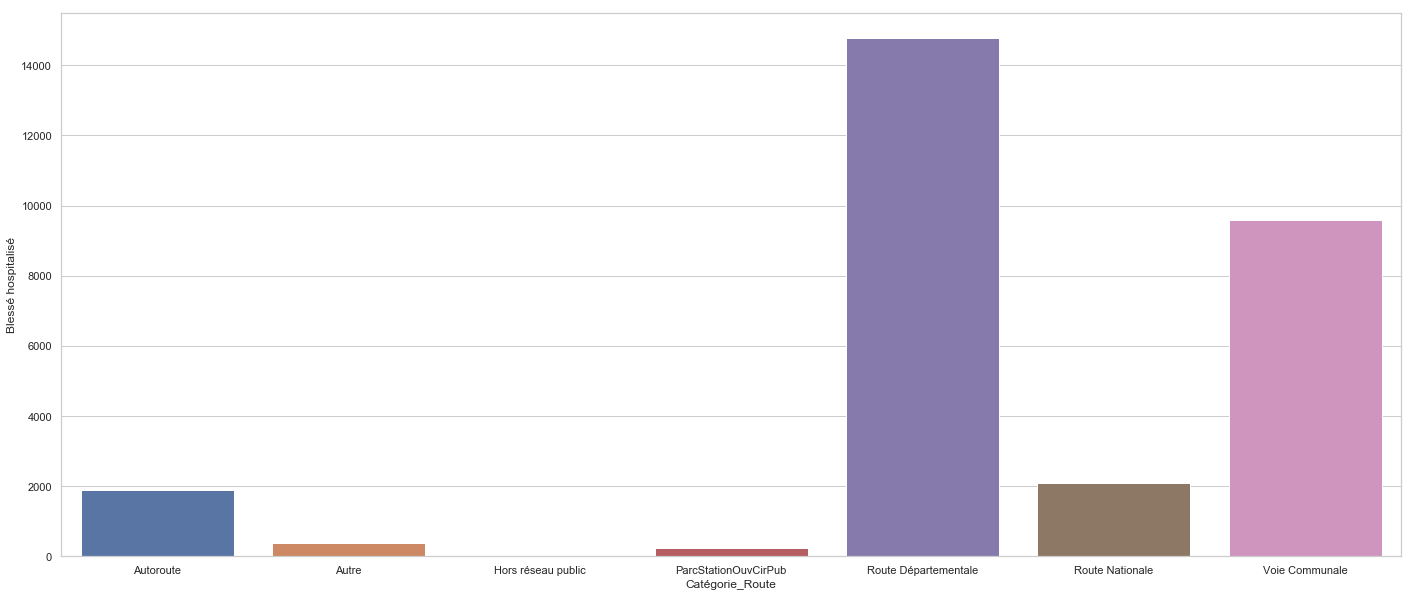

In [38]:
plt.figure(figsize=(24,10))
sns.set(style="whitegrid")
sns.barplot(x='Catégorie_Route', y='Blessé hospitalisé', data=byRoadType)

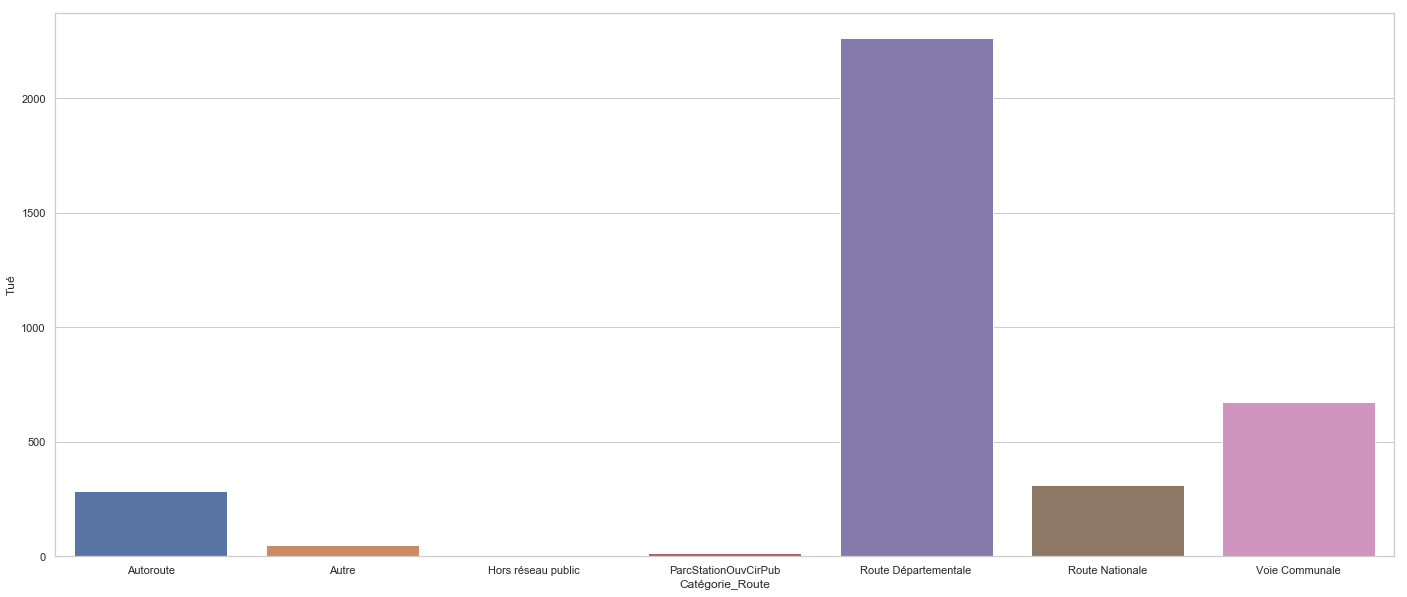

In [39]:
plt.figure(figsize=(24,10))
sns.set(style="whitegrid")
sns.barplot(x='Catégorie_Route', y='Tué', data=byRoadType)


*Les Accidents, Cas graves et les cas mortels ont été regroupés par la catégorie de routes où ils ont couru et repréentés dans les histogrammes ci-dessus.
On constate que la voie communale est la plus sensible aux accidents mais quad il s'agit des degrés sévères d'accident c'est la route départmentale qui est la plus dangereuse .

### Groupement et normisation par Commune 

In [36]:
population = pd.read_csv(r"populat.csv",sep=";")
population.head()

Code INSEE  Code Postal                Commune     Département  \
0      32460        32720             VERGOIGNAN            GERS   
1      51141        51240  LA CHAUSSEE-SUR-MARNE           MARNE   
2      77130        77580              COULOMMES  SEINE-ET-MARNE   
3      63379        63460             SAINT-MYON     PUY-DE-DOME   
4      62050        62770       AUCHY-LES-HESDIN   PAS-DE-CALAIS   

               Région          Statut  Altitude Moyenne  Superficie  \
0       MIDI-PYRENEES  Commune simple             126.0      1056.0   
1   CHAMPAGNE-ARDENNE  Commune simple             130.0      2240.0   
2       ILE-DE-FRANCE  Commune simple             136.0       371.0   
3            AUVERGNE  Commune simple             365.0       556.0   
4  NORD-PAS-DE-CALAIS  Commune simple              72.0       986.0   

   Population                    geo_point_2d  \
0         0.3  43.7235746425, -0.188266221507   
1         0.7    48.8433156105, 4.54286173009   
2         0.4    48.8919104938, 2.92942534432   
3         0.4    45.9871537427, 3.12955448011   
4         1.7    50.4085719795, 2.09530419017   

                                           geo_shape  ID Geofla  Code Commune  \
0  {"type": "Polygon", "coordinates": [[[-0.19884...      34962           460   
1  {"type": "Polygon", "coordinates": [[[4.504753...      18178           141   
2  {"type": "Polygon", "coordinates": [[[2.940606...      31737           130   
3  {"type": "Polygon", "coordinates": [[[3.137773...      19489           379   
4  {"type": "Polygon", "coordinates": [[[2.105157...      18166            50   

   Code Canton  Code Arrondissement Code Département  Code Région  
0           24                    3               32           73  
1           33                    4               51           21  
2            8                    1               77           11  
3           14                    4               63           83  
4           39                    4               62           31

In [37]:
#Grouper par Commune
parCommune = dummies.groupby('Commune').sum()
#Ajouter les données de populaiton pour les communes
parCommune = parCommune.join(population,how='left')
parCommune.drop('hour',axis=1,inplace=True)

#Claculé degré d'accidents /1000 résidents
parCommune['AccPerKPerson'] = (parCommune['Nombre_Accident']/parCommune['Population'])*1000
parCommune['GravePerKPerson'] = (parCommune['Blessé hospitalisé']/parCommune['Population'])*1000
parCommune['MortPerKPerson'] = (parCommune['Tué']/parCommune['Population'])*1000

# Liste des valeurs des variables de conditions environnementales qu'on veut investiger

lumCols = ['Conditions_lumière_Crépuscule ou aube',
       'Conditions_lumière_Nuit avec éclairage public allumé',
       'Conditions_lumière_Nuit avec éclairage public non allumé',
       'Conditions_lumière_Nuit sans éclairage public',
       'Conditions_lumière_Plein jour']

atmCols = ['Atmosphere_Brouillard fumée', 'Atmosphere_Neige-gêlé',
       'Atmosphere_Normale', 'Atmosphere_Pluie forte',
       'Atmosphere_Pluie légère', 'Atmosphere_Temps couvert',
       'Atmosphere_Temps eblouissant', 'Atmosphere_Vent fort-tempête']

surfCols = ['Conditions_Surface_Autre',
       'Conditions_Surface_Boue', 'Conditions_Surface_Corps gras-huile',
       'Conditions_Surface_Enneigée', 'Conditions_Surface_Flaques',
       'Conditions_Surface_Inondée', 'Conditions_Surface_Mouillée',
       'Conditions_Surface_Normale', 'Conditions_Surface_Verglacée']

toutesCols = ['Conditions_lumière_Crépuscule ou aube',
       'Conditions_lumière_Nuit avec éclairage public allumé',
       'Conditions_lumière_Nuit avec éclairage public non allumé',
       'Conditions_lumière_Nuit sans éclairage public',
       'Conditions_lumière_Plein jour', 'Atmosphere_Autre',
       'Atmosphere_Brouillard fumée', 'Atmosphere_Neige-gêlé',
       'Atmosphere_Normale', 'Atmosphere_Pluie forte',
       'Atmosphere_Pluie légère', 'Atmosphere_Temps couvert',
       'Atmosphere_Temps eblouissant', 'Atmosphere_Vent fort-tempête',
       'Conditions_Surface_Autre',
       'Conditions_Surface_Boue', 'Conditions_Surface_Corps gras-huile',
       'Conditions_Surface_Enneigée', 'Conditions_Surface_Flaques',
       'Conditions_Surface_Inondée', 'Conditions_Surface_Mouillée',
       'Conditions_Surface_Normale', 'Conditions_Surface_Verglacée']

parCommuneProp = parCommune[toutesCols].copy()
for col in parCommuneProp.columns.values:
    for row in parCommuneProp.index:
        parCommuneProp.loc[row,col] = parCommuneProp.loc[row,col]/parCommune.loc[row,'Nombre_Accident']
        
scaler = MinMaxScaler(feature_range=(0,1),copy=True)

#Normaliser les valuers avec le quantile transform
parCommuneNorm = pd.DataFrame(data=quantile_transform(parCommuneProp.copy()), index=parCommuneProp.index, columns=parCommuneProp.columns.values).copy()



In [38]:
parCommune.head()

Nombre_Accident  Blessé hospitalisé   Tué  \
Commune                                              
1.0                382.0               186.0  20.0   
2.0                222.0                82.0  13.0   
3.0                187.0               112.0  13.0   
4.0                555.0               187.0  28.0   
5.0                408.0               162.0  12.0   

         Conditions_lumière_Crépuscule ou aube  \
Commune                                          
1.0                                         28   
2.0                                         14   
3.0                                         18   
4.0                                         35   
5.0                                         28   

         Conditions_lumière_Nuit avec éclairage public allumé  \
Commune                                                         
1.0                                                     63      
2.0                                                     25      
3.0                                                     24      
4.0                                                    101      
5.0                                                     42      

         Conditions_lumière_Nuit avec éclairage public non allumé  \
Commune                                                             
1.0                                                      3          
2.0                                                      2          
3.0                                                      0          
4.0                                                      5          
5.0                                                      7          

         Conditions_lumière_Nuit sans éclairage public  \
Commune                                                  
1.0                                                 50   
2.0                                                 17   
3.0                                                 16   
4.0                                                 33   
5.0                                                 55   

         Conditions_lumière_Plein jour  Atmosphere_Autre  \
Commune                                                    
1.0                                238                 2   
2.0                                164                 1   
3.0                                129                 0   
4.0                                381                 2   
5.0                                276                 5   

         Atmosphere_Brouillard fumée       ...        \
Commune                                    ...         
1.0                                1       ...         
2.0                                1       ...         
3.0                                0       ...         
4.0                                2       ...         
5.0                                4       ...         

                                                 geo_shape  ID Geofla  \
Commune                                                                 
1.0      {"type": "Polygon", "coordinates": [[[4.504753...      18178   
2.0      {"type": "Polygon", "coordinates": [[[2.940606...      31737   
3.0      {"type": "Polygon", "coordinates": [[[3.137773...      19489   
4.0      {"type": "Polygon", "coordinates": [[[2.105157...      18166   
5.0      {"type": "Polygon", "coordinates": [[[5.544664...      35080   

         Code Commune  Code Canton  Code Arrondissement  Code Département  \
Commune                                                                     
1.0               141           33                    4                51   
2.0               130            8                    1                77   
3.0               379           14                    4                63   
4.0                50           39                    4                62   
5.0                20           29                    3                13   

         Code Région  AccPerKPerson  GravePerKPerson  MortPerKPers

## Segmentation sur les communes 

In [39]:

####### Essayez de trouver des clusters sensibles aux differents conditions environnementales ###################

#Segementer les communes par les differents attributs
cluster1 = KMeans(n_clusters=3).fit(parCommuneProp[toutesCols])
cluster2 = KMeans(n_clusters=3).fit(parCommuneProp[lumCols])
cluster3 = KMeans(n_clusters=3).fit(parCommuneProp[atmCols])
cluster4 = KMeans(n_clusters=3).fit(parCommuneProp[surfCols])

#Ajouter les clusters à la table parCommune
parCommune['cluster1'] = cluster1.labels_
parCommune['cluster2'] = cluster2.labels_
parCommune['cluster3'] = cluster3.labels_
parCommune['cluster4'] = cluster4.labels_

parCommuneProp['cluster1'] = cluster1.labels_
parCommuneProp['cluster2'] = cluster2.labels_
parCommuneProp['cluster3'] = cluster3.labels_
parCommuneProp['cluster4'] = cluster4.labels_


In [40]:
parCommune.head()

Nombre_Accident  Blessé hospitalisé   Tué  \
Commune                                              
1.0                382.0               186.0  20.0   
2.0                222.0                82.0  13.0   
3.0                187.0               112.0  13.0   
4.0                555.0               187.0  28.0   
5.0                408.0               162.0  12.0   

         Conditions_lumière_Crépuscule ou aube  \
Commune                                          
1.0                                         28   
2.0                                         14   
3.0                                         18   
4.0                                         35   
5.0                                         28   

         Conditions_lumière_Nuit avec éclairage public allumé  \
Commune                                                         
1.0                                                     63      
2.0                                                     25      
3.0                                                     24      
4.0                                                    101      
5.0                                                     42      

         Conditions_lumière_Nuit avec éclairage public non allumé  \
Commune                                                             
1.0                                                      3          
2.0                                                      2          
3.0                                                      0          
4.0                                                      5          
5.0                                                      7          

         Conditions_lumière_Nuit sans éclairage public  \
Commune                                                  
1.0                                                 50   
2.0                                                 17   
3.0                                                 16   
4.0                                                 33   
5.0                                                 55   

         Conditions_lumière_Plein jour  Atmosphere_Autre  \
Commune                                                    
1.0                                238                 2   
2.0                                164                 1   
3.0                                129                 0   
4.0                                381                 2   
5.0                                276                 5   

         Atmosphere_Brouillard fumée    ...     Code Arrondissement  \
Commune                                 ...                           
1.0                                1    ...                       4   
2.0                                1    ...                       1   
3.0                                0    ...                       4   
4.0                                2    ...                       4   
5.0                                4    ...                       3   

         Code Département  Code Région  AccPerKPerson  GravePerKPerson  \
Commune                                                                  
1.0                    51           21  545714.285714    265714.285714   
2.0                    77           11  555000.000000    205000.000000   
3.0                    63           83  467500.000000    280000.000000   
4.0                    62           31  326470.588235    110000.000000   
5.0                    13           93  194285.714286     77142.857143   

         MortPerKPerson  cluster1  cluster2  cluster3  cluster4  
Commune                                                          
1.0        28571.428571         0         2         1         0  
2.0        32500.000000         0         2         2         0  
3.0        32500.000000         0         2         2         0  
4.0        16470.588235         0         2         1         0  
5.0         5714.285714         0         2         2         0  

[5 rows x 51 columns]

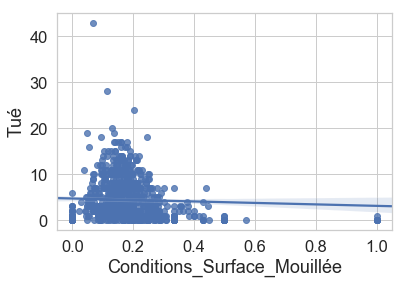

In [81]:
# PLot relationships out
sns.regplot(x='Conditions_Surface_Mouillée',
            y='Tué',
            data=pd.concat((parCommuneProp['Conditions_Surface_Mouillée'],
                          parCommune['Tué']),axis=1))

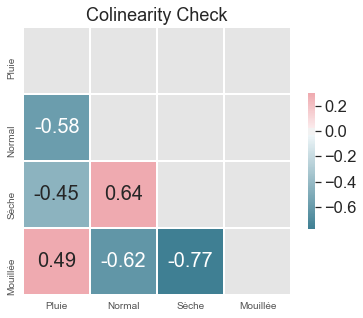

In [42]:
#%% Colinéarité entre les variables 

# Compute the correlation matrix
colin = parCommuneProp[['Atmosphere_Pluie légère',
                        'Atmosphere_Normale',
                        'Conditions_Surface_Normale',
                        'Conditions_Surface_Mouillée']]

labels = np.array(['Pluie',
                   'Normal',
                   'Sèche',
                   'Mouillée'])
corr = colin.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1.5, style='white')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True,linewidths=.5, xticklabels=labels,yticklabels=labels,cbar_kws={"shrink": .5},annot_kws={"size":20})
ax.set_title('Colinearity Check')
plt.savefig('Colinearity Check.png',bbox_inches='tight')

### Modèle de regression linéaire pour la plus forte corrélation

In [43]:

X = parCommuneProp['Atmosphere_Pluie légère']
y = parCommune['Nombre_Accident']

pCoeff = np.polyfit(X, y, 2)
polynomial = np.poly1d(pCoeff)

In [118]:
# Calculer la valeur de précision du modèle pour chaque commune 
print(np.polyval(pCoeff, X))

[  71.65988347   77.49261296   82.18936347   77.16271166   84.78280333
   84.02738526   75.50186188   78.41976337   80.69192743   78.35083327
   72.13425173   82.35663089   79.88701886   76.65157333   70.40740878
   67.55688148   87.68378362   82.82653718   80.46345489   71.68805076
   89.82159393   81.60368556   84.10247736   70.57394032   80.73550748
   87.20875014   83.82539317   79.20886278   79.25703258   63.87433857
   80.95165531   71.01772829   74.2980123    82.97051574   81.45029536
   86.28881416   89.67030876   81.13462417   86.82873289   77.77898029
   80.56824167   83.19267346   82.52253599   74.77921593   81.13462417
   81.91776522   84.14644978   86.04933312   79.05438739   82.31755012
   85.8506622    82.69732681   83.43135057   69.18847426   69.0497955
   78.41976337   84.83037252   76.77813422   80.08777829   83.11727804
   68.76279228   78.37241189   79.5503255    87.68042783   78.77100168
   85.22815273   89.1575896    88.55935627   74.55436391   83.01113374
   77.5

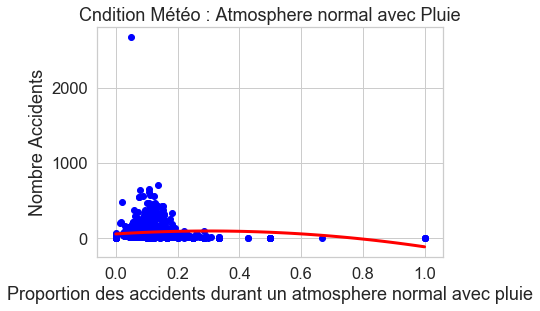

In [44]:
sns.set_style("whitegrid", {'axes.grid' : True})
# Plot Model Results
xp = np.linspace(X.min(), X.max(), 100)
fig5 = plt.figure()
axes = fig5.add_axes([0.1, 0.1, 0.8, 0.8]) 
axes.scatter(X,y,c='blue')
axes.plot(xp, polynomial(xp), linewidth = 3, c='red')
axes.set_title('Cndition Météo : Atmosphere normal avec Pluie')
axes.set_xlabel('Proportion des accidents durant un atmosphere normal avec pluie')
axes.set_ylabel('Nombre Accidents')
plt.savefig('Raining, no high winds vs Accident.png')

In [45]:

#Add cluster labels to byLA and byLAnorm tables
parCommune['cluster4'] = cluster4.labels_
parCommuneProp['cluster4'] = cluster4.labels_
parCommune['cluster4'] = parCommune['cluster4'].astype('str')
parCommuneProp['cluster4'] = parCommuneProp['cluster4'].astype('str')



In [46]:
parCommune.head()

Nombre_Accident  Blessé hospitalisé   Tué  \
Commune                                              
1.0                382.0               186.0  20.0   
2.0                222.0                82.0  13.0   
3.0                187.0               112.0  13.0   
4.0                555.0               187.0  28.0   
5.0                408.0               162.0  12.0   

         Conditions_lumière_Crépuscule ou aube  \
Commune                                          
1.0                                         28   
2.0                                         14   
3.0                                         18   
4.0                                         35   
5.0                                         28   

         Conditions_lumière_Nuit avec éclairage public allumé  \
Commune                                                         
1.0                                                     63      
2.0                                                     25      
3.0                                                     24      
4.0                                                    101      
5.0                                                     42      

         Conditions_lumière_Nuit avec éclairage public non allumé  \
Commune                                                             
1.0                                                      3          
2.0                                                      2          
3.0                                                      0          
4.0                                                      5          
5.0                                                      7          

         Conditions_lumière_Nuit sans éclairage public  \
Commune                                                  
1.0                                                 50   
2.0                                                 17   
3.0                                                 16   
4.0                                                 33   
5.0                                                 55   

         Conditions_lumière_Plein jour  Atmosphere_Autre  \
Commune                                                    
1.0                                238                 2   
2.0                                164                 1   
3.0                                129                 0   
4.0                                381                 2   
5.0                                276                 5   

         Atmosphere_Brouillard fumée    ...     Code Arrondissement  \
Commune                                 ...                           
1.0                                1    ...                       4   
2.0                                1    ...                       1   
3.0                                0    ...                       4   
4.0                                2    ...                       4   
5.0                                4    ...                       3   

         Code Département  Code Région  AccPerKPerson  GravePerKPerson  \
Commune                                                                  
1.0                    51           21  545714.285714    265714.285714   
2.0                    77           11  555000.000000    205000.000000   
3.0                    63           83  467500.000000    280000.000000   
4.0                    62           31  326470.588235    110000.000000   
5.0                    13           93  194285.714286     77142.857143   

         MortPerKPerson  cluster1  cluster2  cluster3  cluster4  
Commune                                                          
1.0        28571.428571         0         2         1         0  
2.0        32500.000000         0         2         2         0  
3.0        32500.000000         0         2         2         0  
4.0        16470.588235         0         2         1         0  
5.0         5714.285714         0         2         2         0  

[5 rows x 51 columns]

### Déterminer les profiles des clusters des communes

In [47]:
#Déterminer les profiles des communes les plus proches au centres des cluster. 

from sklearn.metrics import pairwise_distances_argmin_min

closest1, _ = pairwise_distances_argmin_min(cluster1.cluster_centers_, parCommuneProp[toutesCols])
closest2, _ = pairwise_distances_argmin_min(cluster2.cluster_centers_, parCommuneProp[lumCols])
closest3, _ = pairwise_distances_argmin_min(cluster3.cluster_centers_, parCommuneProp[atmCols])
closest4, _ = pairwise_distances_argmin_min(cluster4.cluster_centers_, parCommuneProp[surfCols])

closest1 = parCommuneProp.iloc[closest1]
closest2 = parCommuneProp.iloc[closest2]
closest3 = parCommuneProp.iloc[closest3]
closest4 = parCommuneProp.iloc[closest4]


c:\users\jileni\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


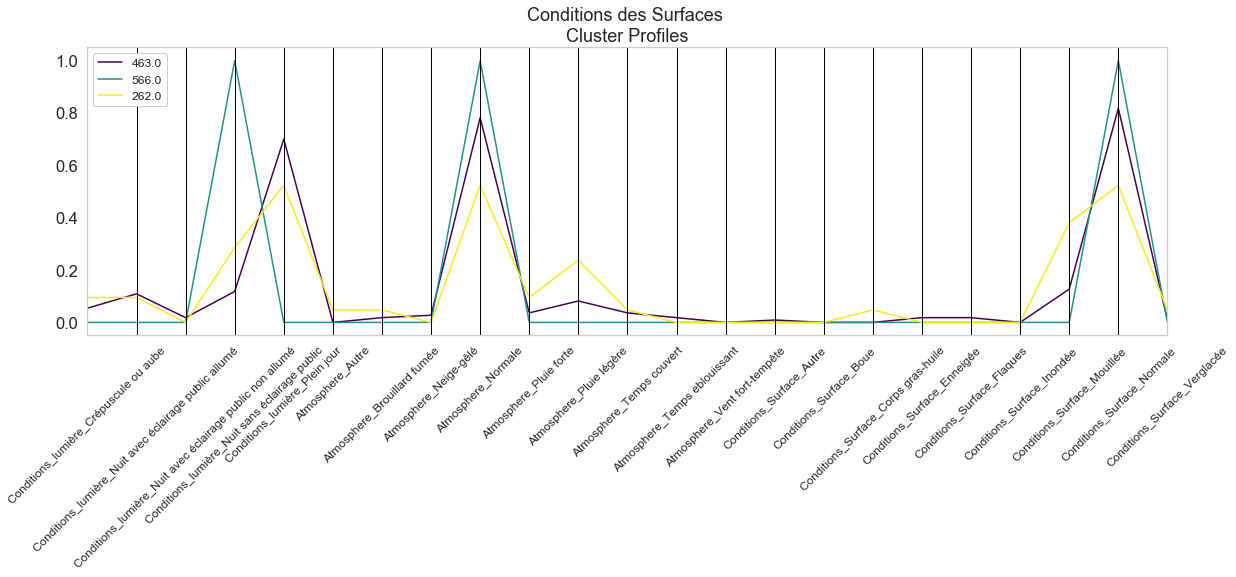

In [79]:
import sys
import pandas
from pandas.tools.plotting import parallel_coordinates

#Plot Parallel Coordinates PLot
fig = plt.figure()
axes = fig.add_axes([0.5, 0.5, 2.5, 1])
parallel_coordinates(pd.concat((closest1[toutesCols],closest1['cluster1']), axis=1), 'cluster1',colormap='viridis')
plt.title('Conditions des Surfaces \nCluster Profiles')
plt.legend(labels=closest4.index,frameon=True,framealpha=1,fontsize=12)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

plt.savefig('Surface PCP ',bbox_inches='tight')

c:\users\jileni\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


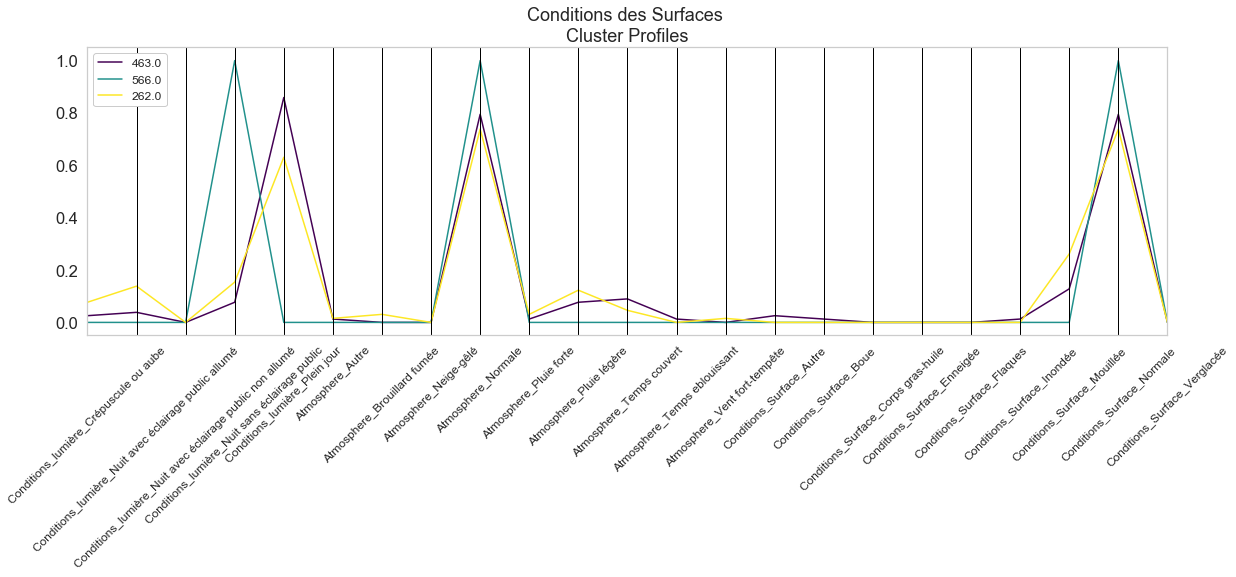

In [77]:
fig = plt.figure()
axes = fig.add_axes([0.5, 0.5, 2.5, 1])
parallel_coordinates(pd.concat((closest2[toutesCols],closest2['cluster2']), axis=1), 'cluster2',colormap='viridis')
plt.title('Conditions des Surfaces \nCluster Profiles')
plt.legend(labels=closest4.index,frameon=True,framealpha=1,fontsize=12)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

plt.savefig('Surface PCP 2',bbox_inches='tight')

c:\users\jileni\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


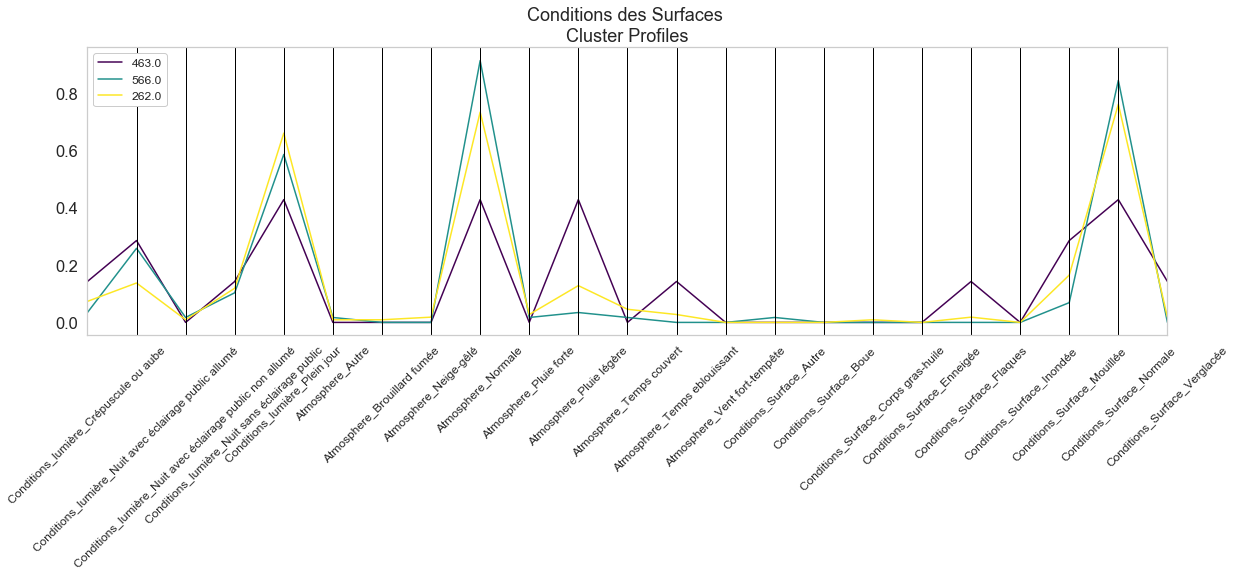

In [76]:
fig = plt.figure()
axes = fig.add_axes([0.5, 0.5, 2.5, 1])
parallel_coordinates(pd.concat((closest3[toutesCols],closest3['cluster3']), axis=1), 'cluster3',colormap='viridis')
plt.title('Conditions des Surfaces \nCluster Profiles')
plt.legend(labels=closest4.index,frameon=True,framealpha=1,fontsize=12)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

plt.savefig('Surface PCP 3 ',bbox_inches='tight')

c:\users\jileni\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


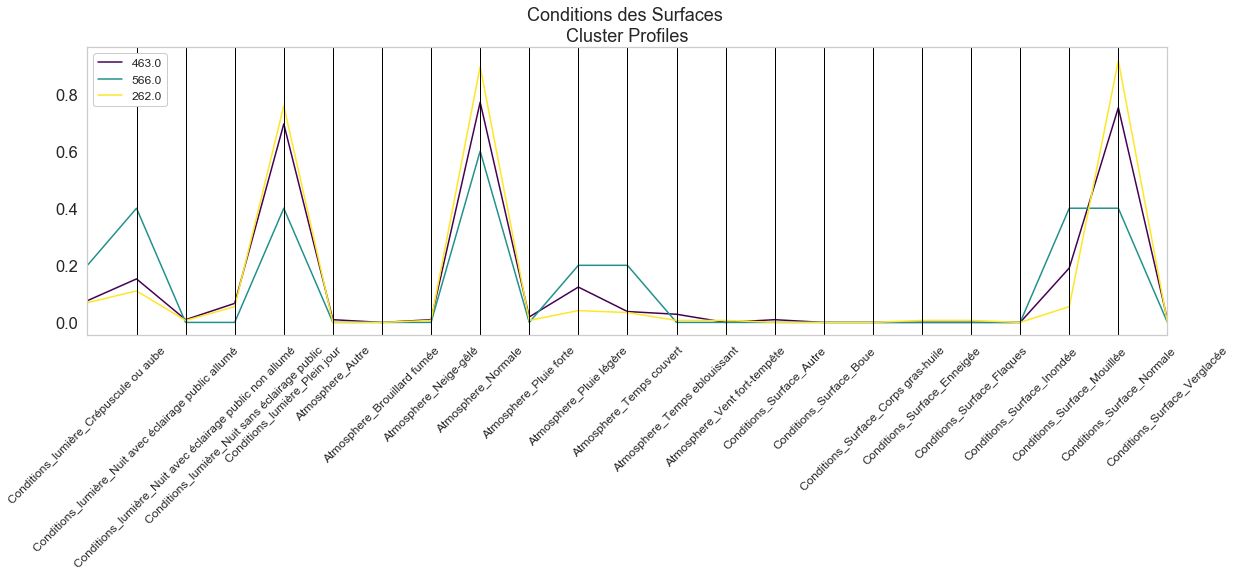

In [73]:
fig = plt.figure()
axes = fig.add_axes([0.5, 0.5, 2.5, 1])
parallel_coordinates(pd.concat((closest4[toutesCols],closest4['cluster4']), axis=1), 'cluster4',colormap='viridis')
plt.title('Conditions des Surfaces \nCluster Profiles')
plt.legend(labels=closest4.index,frameon=True,framealpha=1,fontsize=12)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

plt.savefig('Surface PCP 4',bbox_inches='tight')